In [13]:
import numpy as np
import scipy as sp
from typing import Callable
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

# A3

In [14]:
A=np.array([2,2,1,2,3,1,1,2,2,3,2,1,2,1,1])
B=np.array([3,2,2,2,3,2,2,3,2,2,2,2,2,1,3])

In [15]:
def plug_in_correlation(D:np.ndarray)->float:
    X,Y=D[0],D[1]
    mu_X=np.mean(X,axis=0)
    mu_Y=np.mean(Y,axis=0)
    normalization=(np.sqrt(np.sum((X-mu_X)**2,axis=0))*np.sqrt(np.sum((Y-mu_Y)**2,axis=0)))# you can also use np.sqrt(np.var(X))
    if len(D.shape)==3:zero_var_idx=normalization==0
    if len(D.shape)==3:normalization[zero_var_idx]=1
    rhos=np.sum((X-mu_X)*(Y-mu_Y),axis=0)/normalization
    if len(D.shape)==3: rhos[zero_var_idx]=(mu_X[zero_var_idx]==mu_Y[zero_var_idx])
    return rhos


def boostrap(D:np.ndarray[float,float],f:Callable[[np.ndarray],float],n:int=1000)->np.ndarray[float]:
    N=D.shape[1]
    flattend_D=D.flatten()
    idx=np.random.randint(0,N,size=(N,n))
    resampled_data=np.stack([flattend_D[idx],flattend_D[idx+N]],axis=2).swapaxes(0,2).swapaxes(2,1)
    return resampled_data

In [16]:
data=np.vstack([A,B])
boostraped_data=boostrap(data,0)

In [17]:
boostrap_mean=np.mean(plug_in_correlation(boostraped_data))
boostrap_var=np.var(plug_in_correlation(boostraped_data))
print(f"Sample correlation={plug_in_correlation(data):3f}, Boostrap correlation={boostrap_mean:3f} with variance {boostrap_var:3f}")


Sample correlation=0.325893, Boostrap correlation=0.321268 with variance 0.058734


Using stats.bootstrap

In [18]:
def plug_in_correlation2(X:np.ndarray, Y:np.ndarray)->float:
    mu_X=np.mean(X,axis=0)
    mu_Y=np.mean(Y,axis=0)
    normalization=(np.sqrt(np.var(X,axis=0)))*np.sqrt(np.var(Y,axis=0))
    if normalization==0: return (X==Y).all()
    else: 
        rhos=np.sum((X-mu_X)*(Y-mu_Y))/(X.shape[0]*normalization)
        return rhos.flatten()
    

In [19]:
result=sp.stats.bootstrap((A,B),plug_in_correlation2,paired=True,vectorized=False,method="percentile",n_resamples=1000)
print(np.nanmean(result.bootstrap_distribution),result.standard_error,result.confidence_interval)

0.32210610838234716 [0.24867303] ConfidenceInterval(low=array([-0.18898741]), high=array([0.72664795]))


# A4

In [20]:
m=5
X=m+np.random.standard_normal(size=100)
g_hat_mean=np.exp(np.mean(X))
g_hat_mean

132.24060284553912

In [21]:
result=sp.stats.bootstrap((X,),np.mean,n_resamples=1_000)
g_hat_bootstrap=np.exp(result.bootstrap_distribution)
g_hat_sd=np.sqrt(np.var(g_hat_bootstrap))
g_hat_sd

15.320396141219403

Sample the original distribution for a fair comparison

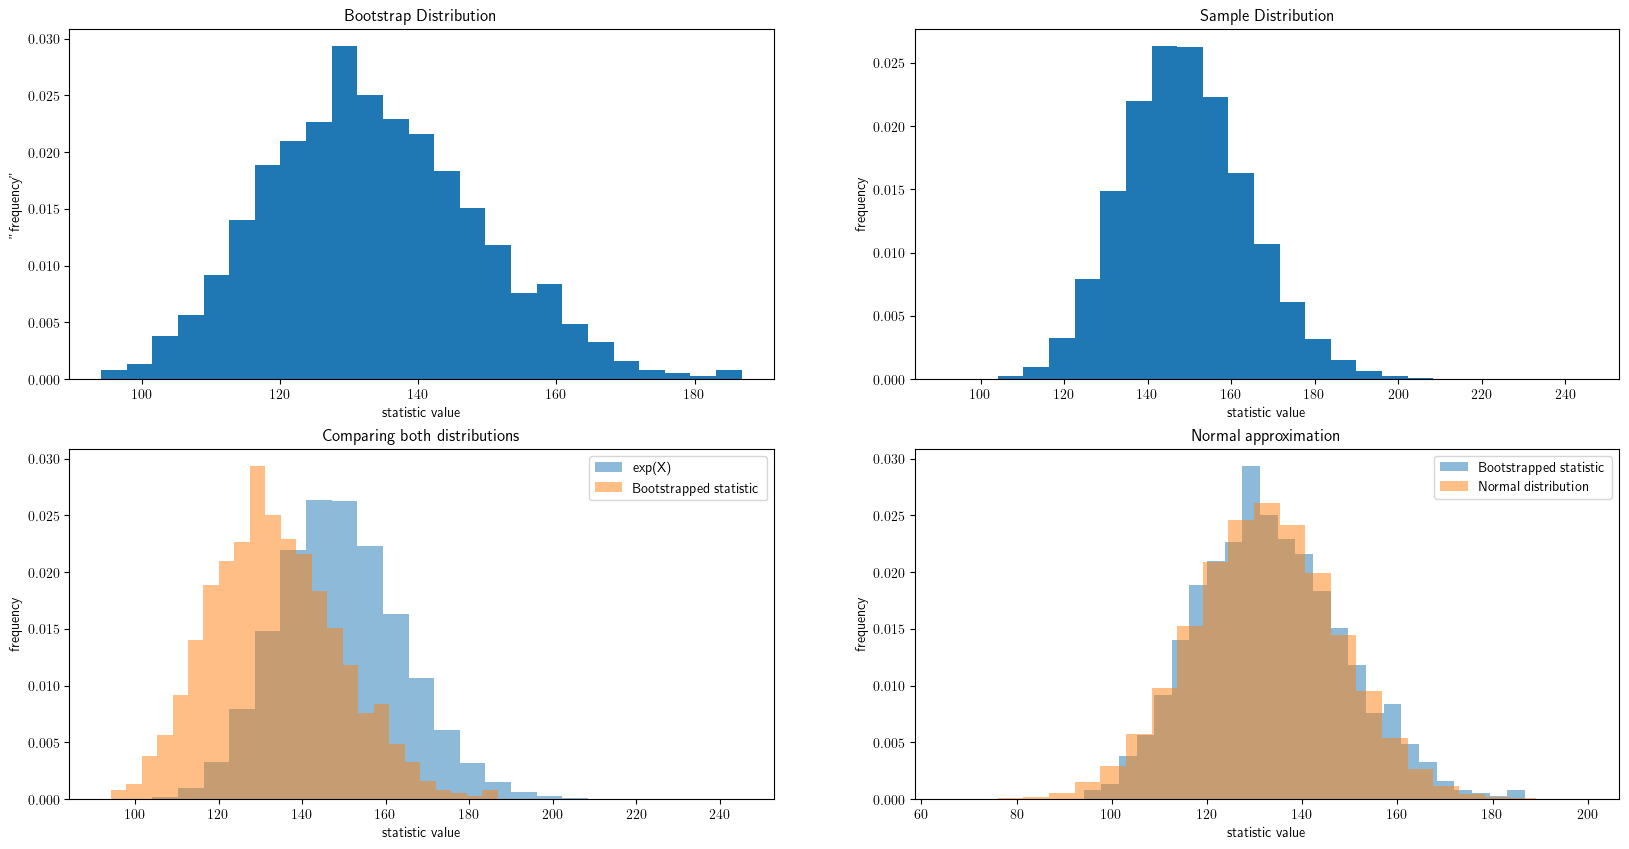

In [22]:
m=5
X=m+np.random.standard_normal(size=(100,1_000_000))
g_hat=np.exp(np.mean(X,axis=0)) # this is log normal distributed

Y=np.random.normal(loc=g_hat_mean,scale=g_hat_sd,size=(100_000))
n_bins=25
fig, axs = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(20,10)
axs[0,0].hist(g_hat_bootstrap, bins=n_bins, density=True)
axs[0,0].set_title("Bootstrap Distribution")
axs[0,0].set_xlabel("statistic value")
axs[0,0].set_ylabel('"frequency"')
axs[0,1].hist(g_hat, bins=n_bins, density=True)
axs[0,1].set_title("Sample Distribution")
axs[0,1].set_xlabel("statistic value")
axs[0,1].set_ylabel("frequency")
axs[1,0].hist(g_hat, bins=n_bins, density=True, alpha=0.5,label="exp(X)")
axs[1,0].hist(g_hat_bootstrap, bins=n_bins, density=True, alpha=0.5,label="Bootstrapped statistic")
axs[1,0].set_title("Comparing both distributions")
axs[1,0].set_xlabel("statistic value")
axs[1,0].set_ylabel("frequency")
axs[1,0].legend()
axs[1,1].set_title("Normal approximation")
axs[1,1].hist(g_hat_bootstrap, bins=n_bins, density=True, alpha=0.5,label="Bootstrapped statistic")
axs[1,1].hist(Y, bins=n_bins, density=True, alpha=0.5,label="Normal distribution")
axs[1,1].set_xlabel("statistic value")
axs[1,1].set_ylabel("frequency")
axs[1,1].legend()
plt.show()

# Bonus: Normal and lognormal

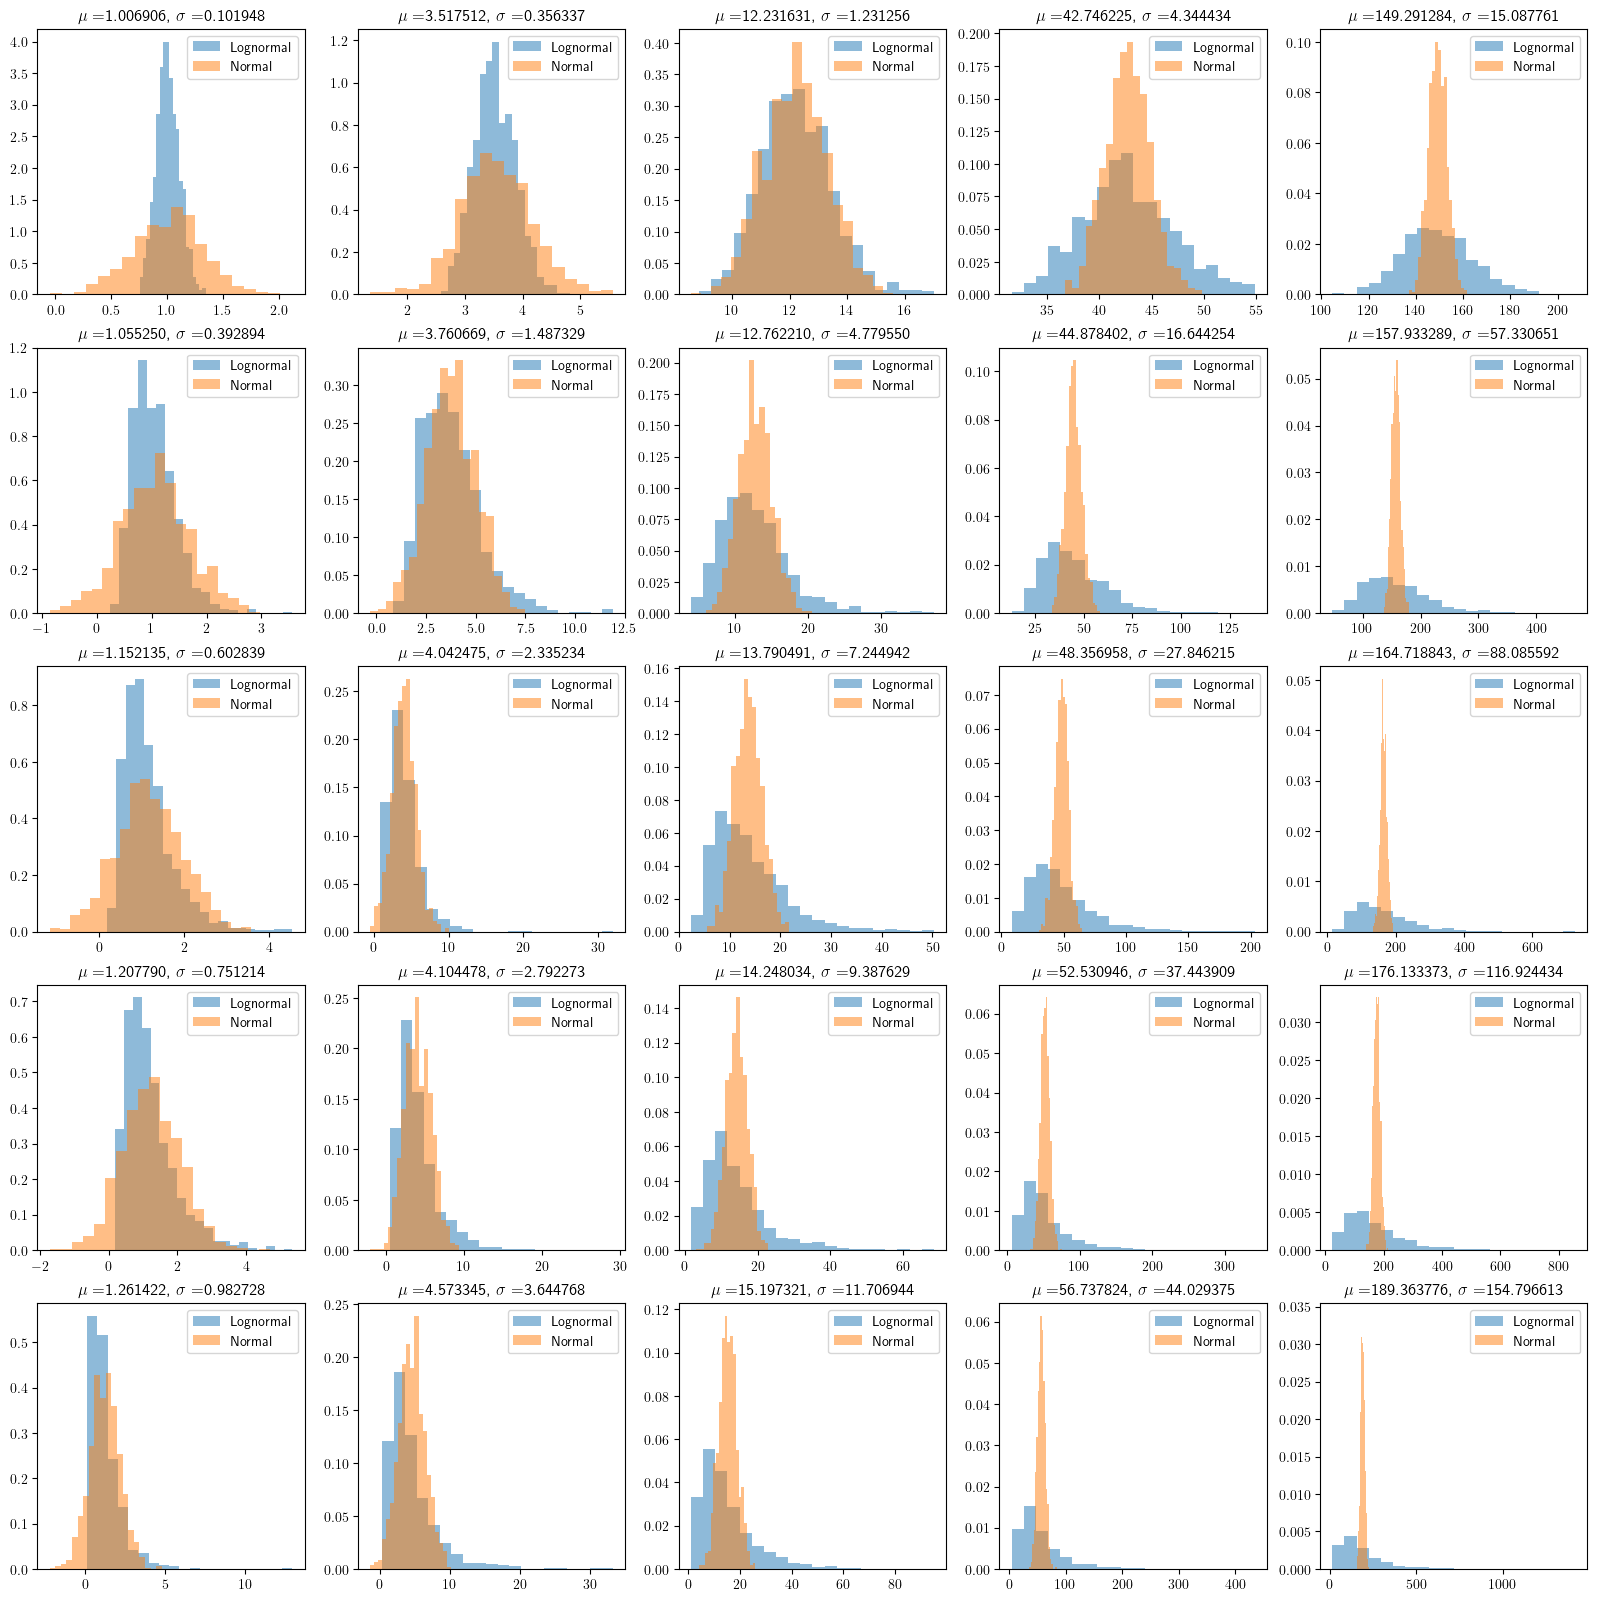

In [37]:
N=5
M=1_000
mu=np.linspace(0,5,num=N)
sigma=np.linspace(0.01,0.5,num=N)
mu_prime,sigma_prime=np.meshgrid(mu,sigma)
data_lognormal=np.exp(np.random.multivariate_normal(mean=mu_prime.flatten(),cov=np.diag(sigma_prime.flatten()),size=M).reshape((M,N,N)))
mu_normal=np.mean(data_lognormal,axis=0)
sigma_normal=np.sqrt(np.var(data_lognormal,axis=0))
data_normal=np.random.multivariate_normal(mean=mu_normal.flatten(),cov=np.diag(sigma_normal.flatten()),size=M).reshape((M,N,N))
n_bins=20
fig, axs = plt.subplots(ncols=5,nrows=5)
fig.set_size_inches(20,20)
for i in range(N**2):
    axs[i//N,i%N].set_title(f"$\\mu=${mu_normal[i//N,i%N]:3f}, $\\sigma=${sigma_normal[i//N,i%N]:3f}")
    axs[i//N,i%N].hist(data_lognormal[:,i//N,i%N], bins=n_bins,density=True, alpha=0.5, label="Lognormal")
    axs[i//N,i%N].hist(data_normal[:,i//N,i%N], bins=n_bins,density=True, alpha=0.5, label="Normal")
    axs[i//N,i%N].legend()
plt.show()

# Or alternatively

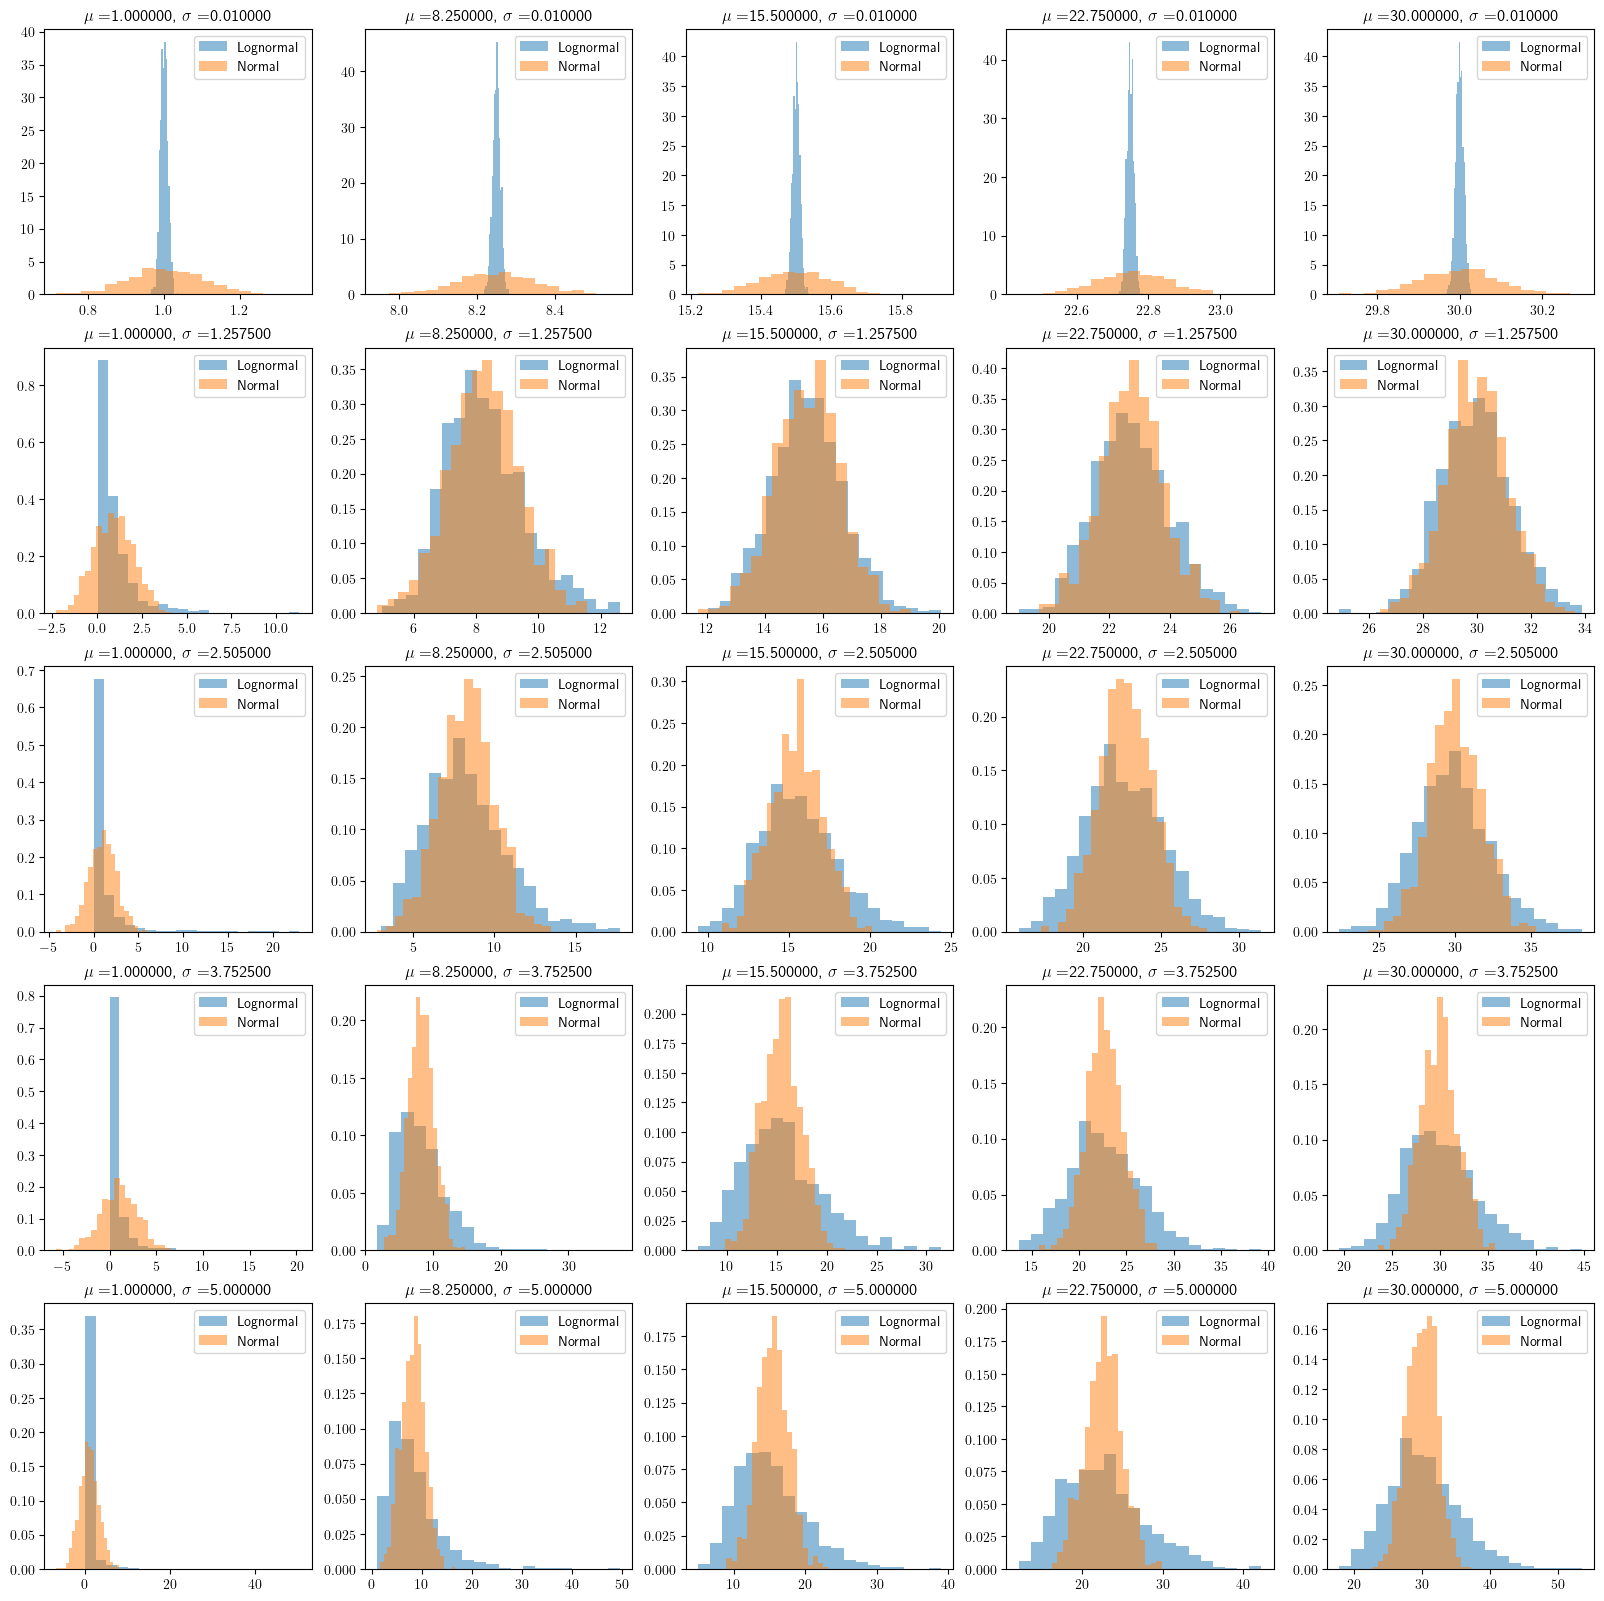

In [47]:
N=5
M=1_000
mu=np.linspace(1,30,num=N)
sigma=np.linspace(0.01,5,num=N)
mu_prime,sigma_prime=np.meshgrid(mu,sigma)
data_normal=np.random.multivariate_normal(mean=mu_prime.flatten(),cov=np.diag(sigma_prime.flatten()),size=M).reshape((M,N,N))
mu_lognormal=np.log(mu_prime**2/(np.sqrt(mu_prime**2+sigma_prime**2)))
sigma_lognormal=np.log(1+(sigma_prime**2)/(mu_prime**2))
data_lognormal=np.exp(np.random.multivariate_normal(mean=mu_lognormal.flatten(),cov=np.diag(sigma_lognormal.flatten()),size=M).reshape((M,N,N)))
n_bins=20
fig, axs = plt.subplots(ncols=5,nrows=5)
fig.set_size_inches(20,20)
for i in range(N**2):
    axs[i//N,i%N].set_title(f"$\\mu=${mu_prime[i//N,i%N]:3f}, $\\sigma=${sigma_prime[i//N,i%N]:3f}")
    axs[i//N,i%N].hist(data_lognormal[:,i//N,i%N], bins=n_bins,density=True, alpha=0.5, label="Lognormal")
    axs[i//N,i%N].hist(data_normal[:,i//N,i%N], bins=n_bins,density=True, alpha=0.5, label="Normal")
    axs[i//N,i%N].legend()
plt.show()